# Import

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder


# Load data

In [2]:
df = pd.read_csv(r"C:\Users\leege\Documents\Capstone\elderly_topical_conversational_sentences.csv")

df['label'].value_counts()

label
short-term    2817
long-term     2213
healthcare    2109
Name: count, dtype: int64

# Feature Extraction

In [3]:
import pandas as pd
import re

HEALTHCARE_KEYWORDS = [
    "clinic", "polyclinic", "hospital", "doctor", "nurse", "medicine",
    "tablet", "capsule", "injection", "pain", "ache", "symptom",
    "treatment", "checkup", "appointment", "blood pressure", "diabetes",
    "cholesterol", "physiotherapy", "rehabilitation", "pharmacy", "scan",
    "surgery", "therapy", "consultation", "vaccination", "prescription"
]

LONGTERM_KEYWORDS = [
    "grandson", "granddaughter", "children", "family", "siblings", "parents",
    "hobby", "gardening", "reading", "knitting", "painting", "cooking",
    "house", "flat", "HDB", "condo", "car", "pet", "cat", "dog",
    "garden", "relatives", "friends", "community", "club", "volunteer",
    "retirement", "savings", "pension"
]

SHORTTERM_KEYWORDS = [
    "today", "tomorrow", "later", "now", "yesterday", "tonight",
    "MRT", "bus", "train", "hawker", "hawker centre", "kopitiam",
    "wet market", "supermarket", "shop", "shopping", "meal", "breakfast",
    "lunch", "dinner", "snack", "queue", "appointment", "errand", "weather",
    "rain", "sunny", "hot", "cold", "event", "celebration", "CNY", "angbao",
    "getai", "festival", "promotion", "sale", "traffic", "delay", "jam"
]

def count_category_words(text, category_words):
    """Count how many words in `text` match `category_words` (case-insensitive)."""
    words = re.findall(r'\b\w+\b', text.lower())
    return sum(1 for w in words if w in category_words)

def add_category_word_counts(df):
    df = df.copy()  # Avoid modifying original df
    df['healthcare_count'] = df['text'].apply(lambda x: count_category_words(x, HEALTHCARE_KEYWORDS))
    df['longterm_count'] = df['text'].apply(lambda x: count_category_words(x, LONGTERM_KEYWORDS))
    df['shortterm_count'] = df['text'].apply(lambda x: count_category_words(x, SHORTTERM_KEYWORDS))
    return df

df = add_category_word_counts(df)
df

,text,label,healthcare_count,longterm_count,shortterm_count
0,I need to collect my blood pressure medicine f...,healthcare,2,0,1
1,My knee has been aching a bit more since the r...,healthcare,0,0,1
2,Did you remember to take your diabetes pills a...,healthcare,1,0,1
3,The doctor at the CHAS clinic told me to reduc...,healthcare,2,0,0
4,I have a physiotherapy appointment next Tuesda...,healthcare,2,0,1
...,...,...,...,...,...
7134,Let's have some Hokkien mee for lunch.,short-term,0,0,1
7135,My daughter just got a new job in a multinatio...,long-term,0,0,0
7136,The new community garden is so beautiful and w...,short-term,0,2,0
7137,My husband and I have been visiting the same h...,long-term,0,0,1


In [23]:
from dotenv import load_dotenv
import os

load_dotenv() 
huggingface_token = os.getenv("HUGGINGFACE_TOKEN")

In [7]:
# Feature Extraction with tf-idf
X_text = df['text'].values
y_text = df['label'].values

# Encode text labels to integers
le = LabelEncoder()
y = le.fit_transform(y_text)
print("Label mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

# TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(X_text).toarray()

# SBERT embeddings
# all-MiniLM-L6-v2 or all-mpnet-base-v2
sbert_model = SentenceTransformer('google/embeddinggemma-300m')
X_sbert = sbert_model.encode(X_text, show_progress_bar=True)

# Categorical features
category_features = df[['healthcare_count', 'longterm_count', 'shortterm_count']].values

# Combine all features
X_hybrid = np.hstack([X_tfidf, X_sbert, category_features])
print("Hybrid feature shape:", X_hybrid.shape)

Label mapping: {'healthcare': 0, 'long-term': 1, 'short-term': 2}


Batches:   0%|          | 0/224 [00:00<?, ?it/s]

Hybrid feature shape: (7139, 1271)


# Training

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train/Validation/Test Split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_hybrid, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

# Logistic Regression with Regularization
log_reg = LogisticRegression(
    C=1.0,                 # adjust for stronger/weaker regularization
    penalty="l2",          # L2 regularization (default)
    solver="lbfgs",        # supports multinomial
    max_iter=2000,         # increase for convergence on large data
    random_state=42
)

log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


# Evaluation


Test Accuracy: 0.9726890756302521

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       422
           1       0.98      0.97      0.97       443
           2       0.96      0.98      0.97       563

    accuracy                           0.97      1428
   macro avg       0.97      0.97      0.97      1428
weighted avg       0.97      0.97      0.97      1428



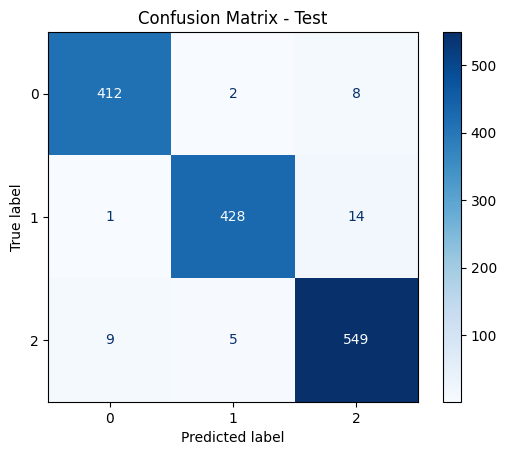

In [11]:
# Test Evaluation
y_test_pred = log_reg.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix - Test
cm_test = confusion_matrix(y_test, y_test_pred, labels=log_reg.classes_)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=log_reg.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test")
plt.show()

In [17]:
import numpy as np
import re

# Define category keywords (should match training)
HEALTHCARE_KEYWORDS = [
    "clinic","polyclinic","hospital","doctor","nurse","medicine",
    "tablet","capsule","injection","pain","ache","symptom",
    "treatment","checkup","appointment","blood pressure","diabetes",
    "cholesterol","physiotherapy","rehabilitation","pharmacy","scan",
    "surgery","therapy","consultation","vaccination","prescription"
]

LONGTERM_KEYWORDS = [
    "grandson","granddaughter","children","family","siblings","parents",
    "hobby","gardening","reading","knitting","painting","cooking",
    "house","flat","HDB","condo","car","pet","cat","dog",
    "garden","relatives","friends","community","club","volunteer",
    "retirement","savings","pension"
]

SHORTTERM_KEYWORDS = [
    "today","tomorrow","tonight","now","yesterday","morning","afternoon","evening",
    "MRT","bus","train","hawker","hawker centre","kopitiam","wet market",
    "supermarket","shop","shopping","meal","breakfast","lunch","dinner","snack",
    "queue","appointment","errand","weather","rain","sunny","hot","cold","event",
    "celebration","CNY","angbao","getai","festival","promotion","sale","traffic",
    "delay","jam"
]

def count_category_words(text, category_words):
    words = re.findall(r'\b\w+\b', text.lower())
    return sum(1 for w in words if w in category_words)
 
def predict_text(new_texts, le):
    """
    Input: 
        new_texts: list of strings
        le: trained LabelEncoder
    Output: predicted labels as original text (e.g., 'healthcare', 'long-term', 'short-term')
    """
    
    # TF-IDF and SBERT
    X_tfidf_new = tfidf_vectorizer.transform(new_texts).toarray()
    X_sbert_new = sbert_model.encode(new_texts, show_progress_bar=False)
    
    # Category word counts
    category_features_new = np.array([
        [
            count_category_words(t, HEALTHCARE_KEYWORDS),
            count_category_words(t, LONGTERM_KEYWORDS),
            count_category_words(t, SHORTTERM_KEYWORDS)
        ]
        for t in new_texts
    ])
    
    # Combine all features
    X_new_hybrid = np.hstack([X_tfidf_new, X_sbert_new, category_features_new])
    
    # Predict integers
    preds_int = log_reg.predict(X_new_hybrid)
    
    # Convert back to original labels
    preds_text = le.inverse_transform(preds_int)
    return preds_text

# Example usage
predict_text(["Forget eat medicine again"],le)

array(['healthcare'], dtype=object)

# Save model (Change directory accordingly)

In [16]:
# Save models
with open("../model_weights/topic_log_reg_hybrid_model.pkl", "wb") as f:
    pickle.dump(log_reg, f)

with open("../model_weights/topic_tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

with open("../model_weights/topic_sbert_model_name.pkl", "wb") as f:
    pickle.dump('google/embeddinggemma-300m', f)

with open('../model_weights/topic_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
    
with open('../model_weights/topic_category_keywords.pkl', 'wb') as f:
    pickle.dump({
        'healthcare': HEALTHCARE_KEYWORDS,
        'longterm': LONGTERM_KEYWORDS,
        'shortterm': SHORTTERM_KEYWORDS
    }, f)

print("Models and artifacts saved.")


Models and artifacts saved.


# Randomized Search - Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

param_dist = {
    'n_estimators': randint(100, 600),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'min_child_weight': randint(1, 6),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0.5, 2)
}

xgb_model = XGBClassifier(
    objective='multi:softprob',  # multi-class
    num_class=3,
    eval_metric='mlogloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=15,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)

# Score
print("Best parameters found:", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

# Eval
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))

# Benchmark speed and results against other models

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pandas as pd
import pickle
import os
import time
from collections import OrderedDict

# -----------------------
# Train/Validation/Test Split
# -----------------------
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_hybrid, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

# -----------------------
# Baseline Models
# -----------------------
models = OrderedDict()

# Add the stacked model first
estimators = [
    ('lgbm', LGBMClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42, verbose=-1)),
    ('xgb', XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1,
                          use_label_encoder=False, eval_metric='mlogloss', random_state=42, verbosity=0)),
    ('lr_base', LogisticRegression(max_iter=500, solver='lbfgs', random_state=42))
]

stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=500, solver='lbfgs', random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

models['Stacked_LGBM_XGB_LR'] = stacked_model

# Then add the rest of the baseline models
models.update({
    "LightGBM": LGBMClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42, verbose=-1),
    "RandomForest": RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=500, solver="lbfgs", random_state=42),
    "SVM": SVC(kernel="linear", C=1.0, probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "NaiveBayes": GaussianNB(),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, use_label_encoder=False,
                             eval_metric='mlogloss', random_state=42, verbosity=0)
})

# -----------------------
# Train, Evaluate, Measure Size & Time
# -----------------------
all_reports = {}
size_dict = {}
time_dict = {}

for name, model in models.items():
    # Train
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    
    # Predict on validation
    start_pred = time.time()
    y_val_pred = model.predict(X_val)
    end_pred = time.time()
    
    # Accuracy & report
    acc = accuracy_score(y_val, y_val_pred)
    print(f"{name} Validation Accuracy: {acc:.4f}")
    
    report = classification_report(y_val, y_val_pred, output_dict=True)
    all_reports[name] = report
    
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_val, y_val_pred))
    
    # Measure size by saving temporarily with pickle
    tmp_file = f"tmp_{name}.pkl"
    with open(tmp_file, "wb") as f:
        pickle.dump(model, f)
    size_mb = os.path.getsize(tmp_file) / (1024 * 1024)
    size_dict[name] = size_mb
    os.remove(tmp_file)
    
    # Inference time per sample (on validation set)
    inference_time_per_sample = (end_pred - start_pred) / len(X_val)
    time_dict[name] = inference_time_per_sample
    
    print(f"{name} Model Size: {size_mb:.2f} MB")
    print(f"{name} Inference Time per Sample: {inference_time_per_sample:.6f} sec\n")

# -----------------------
# Macro-Averaged Comparison
# -----------------------
df_reports = pd.DataFrame({model: all_reports[model]["macro avg"] 
                           for model in all_reports}).T
df_reports = df_reports[["precision", "recall", "f1-score", "support"]]

# Add model size and inference time
df_reports["model_size_MB"] = pd.Series(size_dict)
df_reports["inference_time_sec"] = pd.Series(time_dict)

print("\n\n====== Macro-Averaged Comparison Across Baseline Models ======")
display(df_reports)


c:\Users\leege\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Stacked_LGBM_XGB_LR Validation Accuracy: 0.9741

Classification Report for Stacked_LGBM_XGB_LR:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       422
           1       0.98      0.98      0.98       442
           2       0.97      0.97      0.97       564

    accuracy                           0.97      1428
   macro avg       0.97      0.97      0.97      1428
weighted avg       0.97      0.97      0.97      1428

Stacked_LGBM_XGB_LR Model Size: 0.49 MB
Stacked_LGBM_XGB_LR Inference Time per Sample: 0.000055 sec



c:\Users\leege\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Validation Accuracy: 0.9482

Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       422
           1       0.95      0.95      0.95       442
           2       0.94      0.95      0.94       564

    accuracy                           0.95      1428
   macro avg       0.95      0.95      0.95      1428
weighted avg       0.95      0.95      0.95      1428

LightGBM Model Size: 0.21 MB
LightGBM Inference Time per Sample: 0.000010 sec

RandomForest Validation Accuracy: 0.9118

Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       422
           1       0.93      0.89      0.91       442
           2       0.87      0.94      0.90       564

    accuracy                           0.91      1428
   macro avg       0.92      0.91      0.91      1428
weighted avg       0.91      0.91      0.91      1428

Ran

,precision,recall,f1-score,support,model_size_MB,inference_time_sec
Stacked_LGBM_XGB_LR,0.974471,0.974441,0.974455,1428.0,0.494797,0.000055
LightGBM,0.949420,0.947974,0.948663,1428.0,0.209438,0.000010
RandomForest,0.919582,0.908553,0.912964,1428.0,0.276498,0.000019
GradientBoosting,0.953380,0.952209,0.952774,1428.0,0.192527,0.000032
LogisticRegression,0.975301,0.975394,0.975342,1428.0,0.029757,0.000005
SVM,0.980680,0.980484,0.980581,1428.0,8.366755,0.000705
KNN,0.939005,0.938370,0.938610,1428.0,41.565434,0.000164
NaiveBayes,0.916001,0.923565,0.917713,1428.0,0.058752,0.000067
XGBoost,0.943614,0.941768,0.942642,1428.0,0.170584,0.000007


In [22]:
# Drop 'support' column
df_reports = df_reports.drop(columns=['support'])

# Reset general float display
pd.reset_option('display.float_format')

# Format only inference_time_sec
styled_df = df_reports.style.format({
    'inference_time_sec': '{:.2e}'
})

# Display the styled DataFrame
display(styled_df)


,precision,recall,f1-score,model_size_MB,inference_time_sec
Stacked_LGBM_XGB_LR,0.974471,0.974441,0.974455,0.494797,5.49e-05
LightGBM,0.949420,0.947974,0.948663,0.209438,9.96e-06
RandomForest,0.919582,0.908553,0.912964,0.276498,1.88e-05
GradientBoosting,0.953380,0.952209,0.952774,0.192527,3.22e-05
LogisticRegression,0.975301,0.975394,0.975342,0.029757,4.91e-06
SVM,0.980680,0.980484,0.980581,8.366755,7.05e-04
KNN,0.939005,0.938370,0.938610,41.565434,1.64e-04
NaiveBayes,0.916001,0.923565,0.917713,0.058752,6.73e-05
XGBoost,0.943614,0.941768,0.942642,0.170584,7.35e-06
